In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import xgboost
import shap

from sklearn import metrics
from scipy import stats
from scipy.stats import entropy

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier


from catenets.models.jax import TNet, SNet,SNet1, SNet2, SNet3, DRNet, RANet, PWNet, RNet, XNet
from catenets.experiment_utils.simulation_utils import simulate_treatment_setup

from econml.dr import LinearDRLearner

/homes/gws/mingyulu/miniconda3/envs/torch_gpu/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def kl_mvn(m0, S0, m1, S1):
    """
    https://stackoverflow.com/questions/44549369/kullback-leibler-divergence-from-gaussian-pm-pv-to-gaussian-qm-qv
    The following function computes the KL-Divergence between any two 
    multivariate normal distributions 
    (no need for the covariance matrices to be diagonal)
    Kullback-Liebler divergence from Gaussian pm,pv to Gaussian qm,qv.
    Also computes KL divergence from a single Gaussian pm,pv to a set
    of Gaussians qm,qv.
    Diagonal covariances are assumed.  Divergence is expressed in nats.
    - accepts stacks of means, but only one S0 and S1
    From wikipedia
    KL( (m0, S0) || (m1, S1))
         = .5 * ( tr(S1^{-1} S0) + log |S1|/|S0| + 
                  (m1 - m0)^T S1^{-1} (m1 - m0) - N )
    # 'diagonal' is [1, 2, 3, 4]
    tf.diag(diagonal) ==> [[1, 0, 0, 0]
                          [0, 2, 0, 0]
                          [0, 0, 3, 0]
                          [0, 0, 0, 4]]
    # See wikipedia on KL divergence special case.              
    #KL = 0.5 * tf.reduce_sum(1 + t_log_var - K.square(t_mean) - K.exp(t_log_var), axis=1)   
                if METHOD['name'] == 'kl_pen':
                self.tflam = tf.placeholder(tf.float32, None, 'lambda')
                kl = tf.distributions.kl_divergence(oldpi, pi)
                self.kl_mean = tf.reduce_mean(kl)
                self.aloss = -(tf.reduce_mean(surr - self.tflam * kl))                               
    """
    # store inv diag covariance of S1 and diff between means
    N = m0.shape[0]
    iS1 = np.linalg.inv(S1)
    diff = m1 - m0

    # kl is made of three terms
    tr_term   = np.trace(iS1 @ S0)
    det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
    quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
    #print(tr_term,det_term,quad_term)
    return .5 * (tr_term + det_term + quad_term - N) 

In [213]:
def KL_divergence(a, b):
    epsilon = 1e-35 
    a += epsilon
    b += epsilon

    return np.mean(a * np.log(a/b))

def KL_gaussian(a,b, var_a, var_b):
    
    
    return np.log(var_a/var_b)  + (var_a*())

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def mse(x1, x2):
    return (np.mean((x1 - x2)**2))

def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

def simulation(var_size, n, low , high, random_state, oracle=bool):
    
    np.random.seed(random_state)
    cov = np.random.uniform(low=-1, high=1, size=((var_size,var_size)))
    
    ### control 
    #mu0 = np.random.uniform(low = mu0_low, high= mu0_high, size=(var_size))
    mu0 = np.zeros(var_size)
    x0 = np.random.multivariate_normal(mu0, 0.5*cov, size=int(n/2))
    
    ### treated
    mu1 = np.random.uniform(low = low, high=high, size=(var_size))
    x1 = np.random.multivariate_normal(mu1, 0.5*cov, size=int(n/2))
    
    X = np.concatenate((x0, x1))
    
    #### Treatment assignment
    w_t = np.random.uniform(low=-0.1, high=0.1, size=((var_size,1)))
    n_t = np.random.normal(0, 0.1)
    
    p = sigmoid(np.dot(X, w_t) + n_t)

    w = np.concatenate((np.zeros((int(n/2),1)), np.ones((int(n/2),1 ))), 0).astype(int)
    #### Potential outcome
    if oracle:
        p = 0.5*np.ones((n,1))
        w = np.random.binomial(1, p=p)
    
    w_ty = np.random.uniform(low=-1, high=1, size=((var_size,2)))
    n_ty = np.random.multivariate_normal(np.zeros((2)), 0.1*np.eye(2))    
    y_po = np.dot(X, w_ty) + n_ty

    return X, y_po, w, p, kl_mvn(mu0, 0.5*cov, mu1, 0.5*cov)

In [293]:
n = 3000
feature_size = 20
random_state = 0
mu1_low, mu1_high = -2.55, -2.7
X, y_po, w, p, KL = simulation(feature_size, n, mu1_low, mu1_high, random_state, False)


print(KL)
rng = np.random.default_rng(random_state)
inds = np.arange(n)
rng.shuffle(inds)

n_train = int(0.8 * n)

train_inds = inds[:n_train]
test_inds = inds[n_train:]

x_train, x_test = X[train_inds,:], X[test_inds,:]
w_train = w[train_inds]
y_train = np.take_along_axis(y_po,w, 1)[train_inds, :]
y_test_cate = y_po[test_inds, 1] - y_po[test_inds, 0]

112.67463155981443


covariance is not positive-semidefinite.
covariance is not positive-semidefinite.


(array([  6.,  41., 139., 382., 659., 817., 581., 278.,  85.,  12.]),
 array([0.27811307, 0.32535842, 0.37260377, 0.41984912, 0.46709448,
        0.51433983, 0.56158518, 0.60883053, 0.65607588, 0.70332124,
        0.75056659]),
 <BarContainer object of 10 artists>)

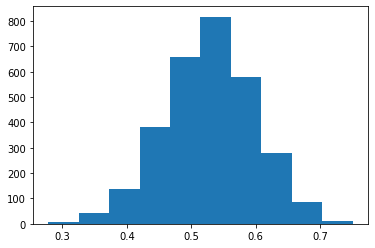

In [185]:
plt.hist(p)

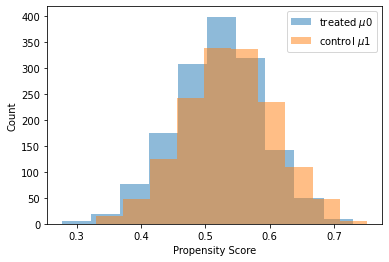

In [184]:
treated_p = np.multiply(p, w)
control_p = np.multiply(p, 1-w)

plt.hist(treated_p[treated_p>0], label = "treated $\mu0$", alpha = 0.5)
plt.hist(control_p[control_p > 0], label = "control $\mu1$", alpha = 0.5)

plt.ylabel("Count")
plt.xlabel("Propensity Score")
#plt.title('KL divergence %s' % KL(mu_1,mu_0))
plt.legend()


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
Permutation explainer: 1001it [00:43, 17.88it/s]                                  


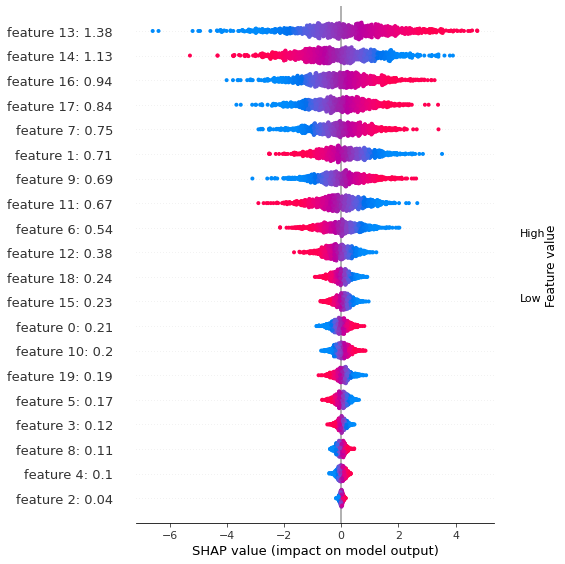

In [114]:
est = LinearDRLearner(model_propensity=GradientBoostingClassifier(),
                      model_regression=GradientBoostingRegressor())

est.fit(y_train, w_train, X=x_train)
treatment_effects = est.effect(x_test)

lb, ub = est.effect_interval(x_test, alpha=0.05)
#est.fit(y_train, w_train, X=x_train)
#shap_values_1 = est.shap_values(x_test)

def est_predict(X):
    return est.effect(X)

explainer = shap.Explainer(est_predict, x_train)

#### showing explanation on cate
shap_values = explainer(x_test)

names = ["feature " + str(i) for i in range(feature_size)]
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

shap.summary_plot(shap_values, feature_names=feature_names)

ecom_biased = (shap_values.values).mean(0)
ecom_biased_abs = np.abs(shap_values.values).mean(0)

In [126]:
est_pred = est.effect(x_test)

pehe_1 = mse(y_test_cate, est_pred)
print(pehe_1)
print(stats.spearmanr(ecom_unbiased, ecom_biased).correlation, stats.spearmanr(ecom_unbiased_abs, ecom_biased_abs).correlation)

20.864168493795134
0.7533834586466165 0.11428571428571428


Permutation explainer: 601it [01:04,  7.76it/s]                                   


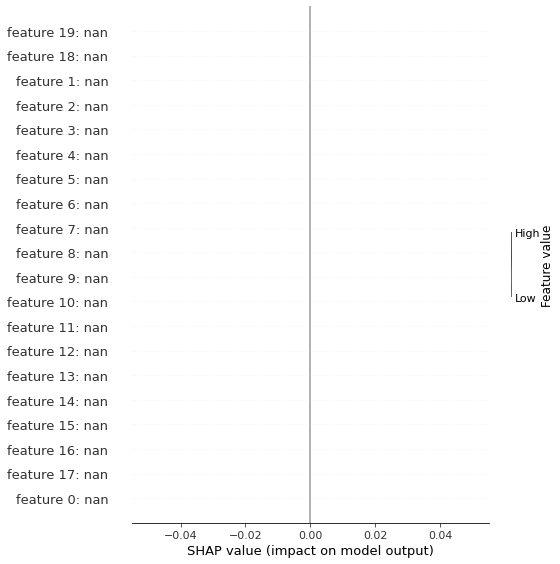

In [291]:
### single learner as oracle
dr = RNet(nonlin="relu")

if "SNet" in str(dr):
    print(str(dr))


X = (x_train)
dr.fit((X), y_train, w_train)


def dr_predict(X):
    return dr.predict(X)

explainer = shap.Explainer(dr_predict, x_train)

#### showing explanation on cate
shap_values = explainer(x_test)

names = ["feature " + str(i) for i in range(feature_size)]
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

shap.summary_plot(shap_values, feature_names=feature_names)

cate_biased = (shap_values.values).mean(0)
cate_biased_abs = np.abs(shap_values.values).mean(0)

In [292]:
est_pred = dr_predict(x_test)

pehe_1 = mse(y_test_cate, est_pred)
print(pehe_1)
print(stats.spearmanr(cate_unbiased, cate_biased).correlation, stats.spearmanr(cate_unbiased_abs, cate_biased_abs).correlation)

nan
nan nan


In [247]:
print(y_train.shape)
print(NormalizeData(x_train))

print(w_train.shape)

(2400, 1)
[[0.44476692 0.44228323 0.48299892 ... 0.60251774 0.64116683 0.44514251]
 [0.37229945 0.38920532 0.49428886 ... 0.46853969 0.36755047 0.56683123]
 [0.62529571 0.59349559 0.49310989 ... 0.35016917 0.37810559 0.31019192]
 ...
 [0.67123059 0.5554819  0.49990556 ... 0.55899179 0.53751338 0.49659557]
 [0.49037634 0.37165746 0.38886949 ... 0.33634711 0.41432879 0.43176748]
 [0.66970759 0.47020205 0.40395294 ... 0.48264079 0.64031715 0.32815425]]
(2400, 1)


Permutation explainer: 601it [01:02,  8.25it/s]                                   


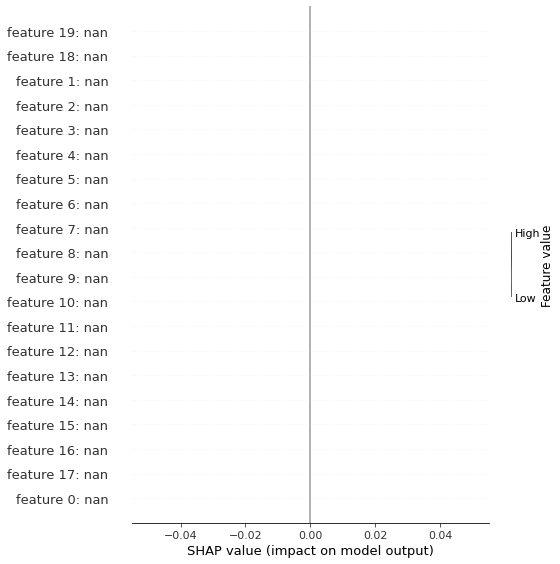

In [297]:
### single learner as oracle

rr = DRNet(nonlin="relu")
rr.fit((x_train), y_train, w_train)

def rr_predict(X):
    return rr.predict(X)

explainer = shap.Explainer(dr_predict, x_train)

#### showing explanation on cate
shap_values = explainer(x_test)

names = ["feature " + str(i) for i in range(feature_size)]
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

shap.summary_plot(shap_values, feature_names=feature_names)

cate_biased = (shap_values.values).mean(0)
cate_biased_abs = np.abs(shap_values.values).mean(0)

In [295]:
est_pred = rr.predict(x_test)
pehe_1 = mse(y_test_cate, est_pred)
print(pehe_1)
print(stats.spearmanr(cate_unbiased, cate_biased).correlation, stats.spearmanr(cate_unbiased_abs, cate_biased_abs).correlation)

390.70297
nan nan


In [170]:
est_pred = est.effect(x_test)

pehe_1 = mse(y_test_cate, est_pred)
pehe_2 = mse(y_test_cate, s_predict(x_test))

print(pehe_1, pehe_2)

96.34349835830608 912.7109


In [69]:
models = [TNet(), SNet() ,SNet1(), SNet2(), SNet3()
          ,DRNet(), RANet(), PWNet(), RNet(), XNet()]

In [85]:
n = 5000
feature_size = 20
random_state = 0

mu_t = np.arange(0, -5.5, -0.5, dtype=float)
print(mu_t)
ecom_spearman_results = np.zeros((len(models), len(mu_t), 2))
cate_spearman_results = np.zeros((len(models), len(mu_t), 2))

pehes = np.zeros((len(models), len(mu_t)))
KL_results = np.zeros(len(mu_t))

### sample training index

rng = np.random.default_rng(random_state)
inds = np.arange(n)
rng.shuffle(inds)

n_train = int(0.8 * n)

train_inds = inds[:n_train]
test_inds = inds[n_train:]

for i, value in enumerate(mu_t):

    mu0_low, mu0_high = value, value - 0.25
    
    
    X, y_po, w, p, KL = simulation(feature_size, n, mu0_low, mu0_high, random_state,True)    

    
    X, y_po, w, p, KL = simulation(feature_size, n, mu0_low, mu0_high, random_state,False)    
    print("KL is %s" %KL)
    
    KL_results[i] = KL
    
    x_train, x_test = X[train_inds,:], X[test_inds,:]
    w_train = w[train_inds,:]
    y_train = np.take_along_axis(y_po,w, 1)[train_inds, :]
    
    y_test_cate = y_po[test_inds, 1] - y_po[test_inds, 0]
    
    #### train CATEs
        
    for model_index, model in enumerate(models):
        cate_net = model
        
        def model_predict(X):
            return cate_net.predict(X)
        
        cate_net.fit(x_train, y_train, w_train)   
        
        #### predict potential outcomes
        
        pred_cate = cate_net.predict(x_test)
        pehe = mse(y_test_cate, pred_cate)
        
        pehes[model_index, i] = pehe
        
        print("PHE %s for model %s"%(pehe,str(cate_net)))

        #### explaining CATE on testing sets.
        
        explainer = shap.Explainer(model_predict, x_train)
        shap_values = explainer(x_test)
        
        feature_imp = (shap_values.values).mean(0).round(2)
        feature_imp_abs = np.abs(shap_values.values).mean(0).round(2)
        
        ecom_spearman_results[model_index, i, 0] = stats.spearmanr(ecom_unbiased , feature_imp).correlation
        ecom_spearman_results[model_index, i, 1] = stats.spearmanr(ecom_unbiased_abs , feature_imp_abs).correlation
        cate_spearman_results[model_index, i, 0] = stats.spearmanr(cate_unbiased , feature_imp).correlation
        cate_spearman_results[model_index, i, 1] = stats.spearmanr(cate_unbiased_abs , feature_imp_abs).correlation
        print(ecom_spearman_results[model_index, i, 0], cate_spearman_results[model_index, i, 0])


[ 0.  -0.5 -1.  -1.5 -2.  -2.5 -3.  -3.5 -4.  -4.5 -5. ]
KL is 0.6833280412283607


covariance is not positive-semidefinite.
covariance is not positive-semidefinite.


PHE 33.427345 for model TNet()


Permutation explainer: 1001it [03:33,  4.47it/s]                                  


0.5073519356638777 0.4575967681247753


KeyboardInterrupt: 

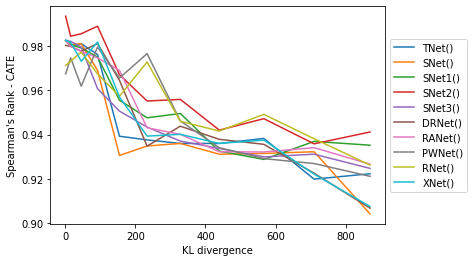

In [367]:
for i in range(len(models)):
    plt.plot(KL_results, ecom_spearman_results[i,:, 0], label=str(models[i]))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Spearman's Rank - CATE")
plt.xlabel("KL divergence")
plt.show()

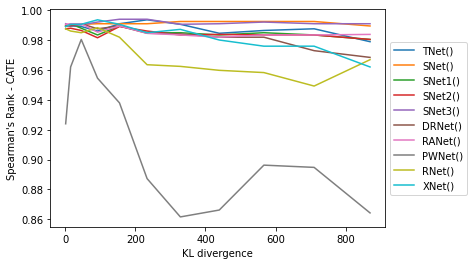

In [368]:
for i in range(len(models)):
    plt.plot(KL_results, ecom_spearman_results[i,:, 1], label=str(models[i]))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Spearman's Rank - CATE")
plt.xlabel("KL divergence")
plt.show()

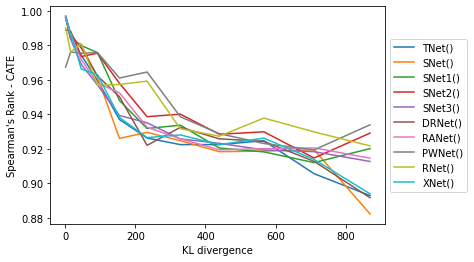

In [369]:
for i in range(len(models)):
    plt.plot(KL_results, cate_spearman_results[i,:, 0], label=str(models[i]))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Spearman's Rank - CATE")
plt.xlabel("KL divergence")
plt.show()

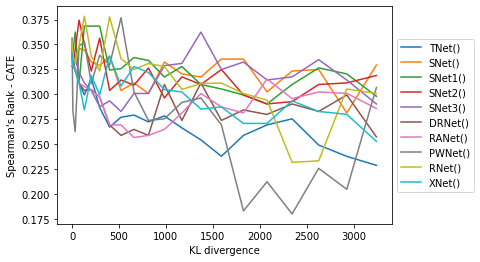

In [336]:
for i in range(len(models)):
    plt.plot(KL_results, cate_spearman_results[i,:, 1], label=str(models[i]))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel("Spearman's Rank - CATE")
plt.xlabel("KL divergence")
plt.show()

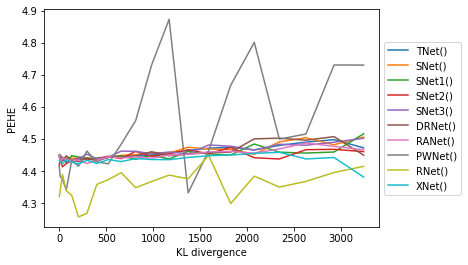

In [337]:
for i in range(len(models)):
    plt.plot(KL_results, pehes[i,:], label=str(models[i]))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("KL divergence")
plt.ylabel("PEHE")
plt.show()

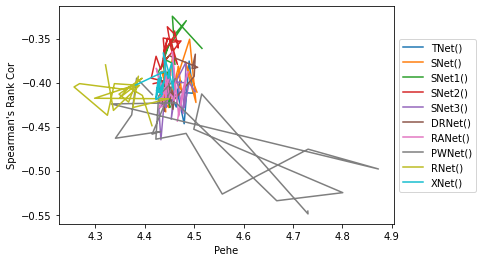

In [338]:
for i in range(len(models)):
    plt.plot(pehes[i,:], ecom_spearman_results[i,:, 0],label=str(models[i]))

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Pehe")
plt.ylabel("Spearman's Rank Cor")
plt.show()

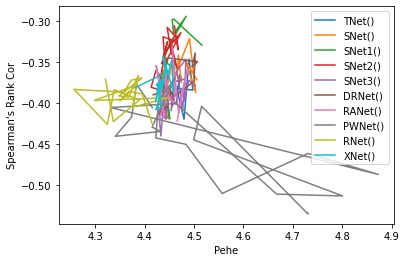

In [339]:
for i in range(len(models)):
    plt.plot(pehes[i,:], cate_spearman_results[i,:, 0],label=str(models[i]))

plt.legend()
plt.xlabel("Pehe")
plt.ylabel("Spearman's Rank Cor")
plt.show()

In [216]:
def t_2net_predict(X):
    return t_2.predict(X)

def tnet_predict(X):
    return t.predict(X)

def snet_predict(X):
    return s.predict(X)

Exact explainer: 1001it [06:02,  2.68it/s]                                        


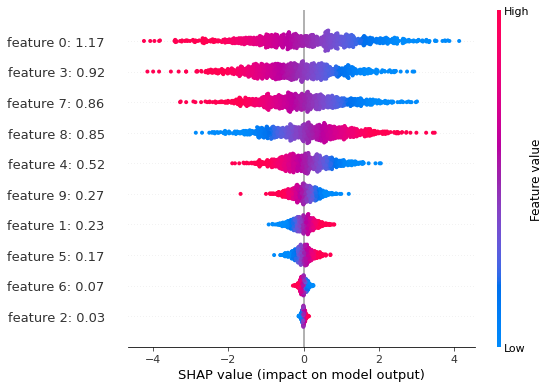

In [ ]:
explainer = shap.Explainer(t_2net_predict, x_train[:,:10])
shap_values = explainer(X_f_test[:, :10])

names = ["feature " + str(i) for i in range(10)]
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

shap.summary_plot(shap_values, feature_names=feature_names)

t_shap = (shap_values.values).mean(0)
t_shap_abs = np.abs(shap_values.values).mean(0)

Exact explainer: 1001it [06:02,  2.68it/s]                                        


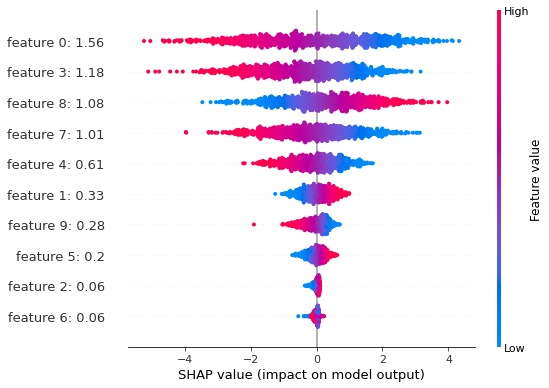

In [140]:
explainer = shap.Explainer(tnet_predict, x_train[:,:10])
shap_values = explainer(X_f_test[:, :10])

names = ["feature " + str(i) for i in range(10)]
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

shap.summary_plot(shap_values, feature_names=feature_names)

t_shap = (shap_values.values).mean(0)
t_shap_abs = np.abs(shap_values.values).mean(0)

Exact explainer: 1001it [06:51,  2.37it/s]                                        


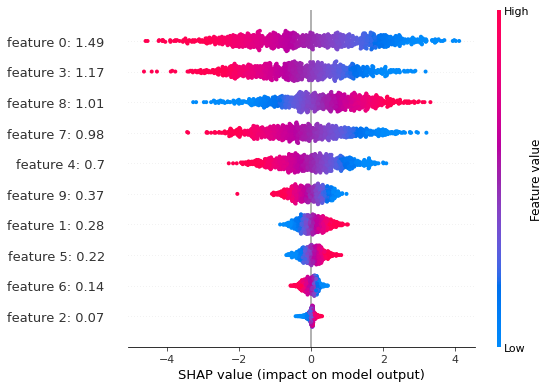

In [141]:
explainer = shap.Explainer(snet_predict, x_train[:,:10])
shap_values = explainer(X_f_test[:, :10])

names = ["feature " + str(i) for i in range(10)]
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

shap.summary_plot(shap_values, feature_names=feature_names)

s_shap = (shap_values.values).mean(0)
s_shap_abs = (np.abs(shap_values.values)).mean(0)

In [93]:
weights = w_ty[:,0] - w_ty[:,1]

stats.spearmanr(weights , unbiased_abs).correlation

0.09090909090909088

In [ ]:
# Load data
X, y = shap.datasets.adult()
X_display, y_display = shap.datasets.adult(display=True)
num_features = X.shape[1]

# Split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [ ]:
from shapreg import removal, games, shapley

# Make model callable
#model_lam = lambda x: model.predict(x)

# Model extension
marginal_extension = removal.MarginalExtension(X_f_test[:, :10], snet_predict)

In [ ]:
# Set up game (single prediction)
instance = x_train[1,:10]
game = games.PredictionGame(marginal_extension, instance)

explanation = shapley.ShapleyRegression(game, batch_size=32)

InvalidIndexError: (1, slice(None, 10, None))

In [ ]:
explanation

Shapley Values(
  (Mean): [[-1.90]
 [-0.43]
 [-0.03]
 [-0.72]
 [-0.36]
 [-0.20]
 [ 0.10]
 [-0.34]
 [-1.23]
 [-0.06]]
  (Std):  [[0.00]
 [0.00]
 [0.00]
 [0.00]
 [0.00]
 [0.00]
 [0.00]
 [0.00]
 [0.00]
 [0.00]]
)

['feature 0', 'feature 1', 'feature 2', 'feature 3', 'feature 4', 'feature 5', 'feature 6', 'feature 7', 'feature 8', 'feature 9']


TypeError: only size-1 arrays can be converted to Python scalars

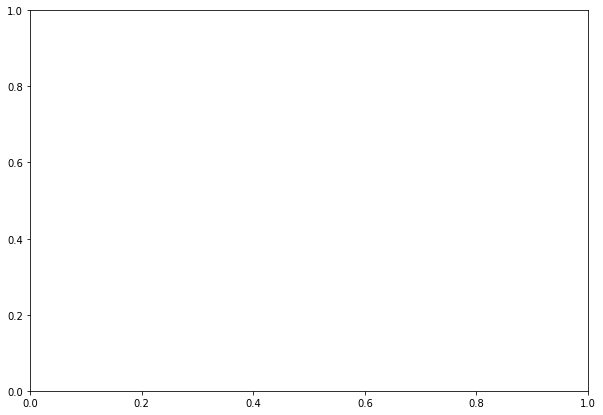

In [ ]:
# Plot with 95% confidence intervals
feature_names = [ "feature %s"% i for i in range(10)]

print(feature_names)

explanation.plot(feature_names, title='SHAP Values', sort_features=False)

In [13]:
w_t = np.random.uniform(low=-0.1, high=0.1, size=((25,1)))
n_t = np.random.normal(0, 0.1)

t_x = sigmoid(np.dot(x0, w_t) + n_t)

NameError: name 'x0' is not defined

In [15]:
# simulate some data (here: unconfounded, 10 prognostic variables and 5 predictive variables)

X, y, w, p, cate = simulate_treatment_setup(n=2000, d = 25, n_o=10, n_t=5, n_c=0)

In [25]:
p

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

invalid value encountered in log


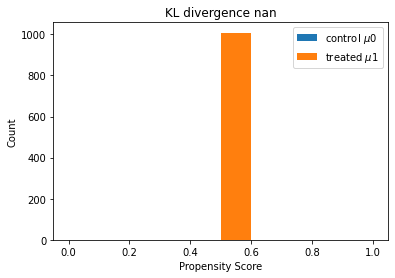

In [30]:
treated_idx = np.where(w==1)
control_idx = np.where(w==0)

treated_outcome = y[treated_idx]
treated_X = X[treated] 
treated_p = p[treated]
mu_1 = np.mean(treated_X,axis=0)

control_outcome = y[control_idx]
control_X = X[control_idx]
control_p = p[control_idx]
mu_0 = np.mean(control_X,axis=0)

plt.hist(treated_p, label = "control $\mu0$")
plt.hist(control_p, label = "treated $\mu1$")

plt.ylabel("Count")
plt.xlabel("Propensity Score")
plt.title('KL divergence %s' % KL(mu_1,mu_0))
plt.legend()

In [31]:
# estimate CATE using TNet
t = TNet()
t.fit(X, y, w)
cate_pred_t = t.predict(X)  # without potential outcomes
cate_pred_t, po0_pred_t, po1_pred_t = t.predict(X, return_po=True)  # predict potential outcomes too

# estimate CATE using SNet
s = SNet(penalty_orthogonal=0.01)
s.fit(X, y, w)
cate_pred_s = s.predict(X)

In [48]:
cate_pred_t.shape
X.shape

(2000, 25)

In [58]:
def f(X):
    return s.predict([X[:,i] for i in range(X.shape[1])]).flatten()

def f(X):
    return s.predict(X)

In [59]:
explainer = shap.Explainer(f, X)
shap_values = explainer(X)

names = ["feature " + str(i) for i in range(11)]
feature_names = [ a + ": " + str(b) for a,b in zip(names, np.abs(shap_values.values).mean(0).round(2))]

shap.summary_plot(shap_values, feature_names=feature_names)

unbiased = (shap_values.values).mean(0)
unbiased_abs = np.abs(shap_values.values).mean(0)

Permutation explainer:  18%|███▍               | 368/2000 [01:53<09:07,  2.98it/s]


KeyboardInterrupt: 